# Wolt Product Lead Task 

## Importing the data from the csv into a Pandas DataFrame

In [562]:
import pandas as pd
import matplotlib
from datetime import datetime, timedelta
import gc

In [563]:
datetime_fields = ['time_received', 'preorder_time', 'client_pre_estimate', 'time_delivered', 'pickup_eta',
                   'delivery_status_log.0.datetime','delivery_status_log.1.datetime',
                   'delivery_status_log.2.datetime','delivery_status_log.3.datetime',
                   'delivery_status_log.4.datetime','delivery_status_log.5.datetime',
                   'delivery_status_log.6.datetime','delivery_status_log.7.datetime',
                   'delivery_status_log.8.datetime','delivery_status_log.9.datetime',
                   'delivery_status_log.10.datetime','delivery_status_log.11.datetime',
                   'delivery_status_log.12.datetime','delivery_status_log.13.datetime',
                   'delivery_status_log.14.datetime','delivery_status_log.15.datetime',
                   'delivery_status_log.16.datetime','delivery_status_log.17.datetime',
                   'delivery_status_log.18.datetime','delivery_status_log.19.datetime',]

In [564]:
def replace_dots_with_underscores(purchases):
    purchases.columns = purchases.columns.str.replace('.', '_')

    return purchases

In [565]:
def read_and_rename_columns():
    purchases = pd.read_csv('purchases.csv', parse_dates=datetime_fields)
    purchases = replace_dots_with_underscores(purchases)
    
    return purchases

In [566]:
purchases = read_and_rename_columns() 

/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (1,3,6,9,10,13,18,23,50,60) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


## Finding the last purchase for each customer

In [567]:
def sort_by_customer_and_date(purchases):
    purchases = purchases.sort_values(by=['from_field_id','time_received'], ascending=True)

    return purchases

In [568]:
def assign_order_num_by_customer(purchases):
    purchases['order_num'] = purchases.groupby(['from_field_id']).cumcount()+1
    
    return purchases

In [569]:
def calculate_max_order_num_by_customer(purchases):
    max_order_num_by_customer = purchases.groupby(['from_field_id'], sort=False)['order_num'].max().reset_index()
    max_order_num_by_customer.columns = ['from_field_id','max_order_num']
    purchases = pd.merge(purchases,max_order_num_by_customer,on='from_field_id',how='left')
    
    return purchases

In [570]:
def find_last_purchase(purchases): 
    purchases = sort_by_customer_and_date(purchases)
    purchases = assign_order_num_by_customer(purchases)
    purchases = calculate_max_order_num_by_customer(purchases)
    purchases['is_last_purchase'] = purchases.apply(lambda x : True if (x['order_num'] == x['max_order_num']) else False, axis=1)
    
    return purchases

In [571]:
purchases = find_last_purchase(purchases)

## Defining "churned" customers
We'll say that a customer who we haven't seen for 4 weeks is a customer who left. Later we'll see a confirmation that this is a valid assumption.

We are also postulating that this analysis is done on the day of the last recorded purchase.

In [572]:
consider_user_churned_after_days = 28
last_purchase_in_db = purchases['time_received'].max()
"Today is {}".format(datetime.date(last_purchase_in_db))

'Today is 2018-06-08'

In [573]:
def define_churned_purchase(purchases):
    purchases['offset_from_now'] = (last_purchase_in_db - purchases['time_received']).dt.days
    purchases['customer_churned'] = purchases.apply(lambda x: True if (x['is_last_purchase'] and x['offset_from_now']>consider_user_churned_after_days) else False, axis=1) 

    return purchases

In [574]:
purchases = define_churned_purchase(purchases)

## Looking for simple churn predictors

In [575]:
def dependency_search(purchases, feature):
    churned = purchases[purchases['customer_churned']==True]
    grouped_by_feature = purchases.groupby([feature])['_id'].count().reset_index()
    grouped_by_feature_churned = churned.groupby([feature])['_id'].count().reset_index()
    grouped_by_feature = pd.merge(grouped_by_feature,grouped_by_feature_churned,on=feature,how='left')
    grouped_by_feature.columns = [feature, 'all', 'churned']                              
    grouped_by_feature['churned_percentage'] = round(100 * grouped_by_feature['churned'] / grouped_by_feature['all'] ,2)
    return grouped_by_feature

,review_rating,all,churned,churned_percentage
0,-1.0,1,NaN,NaN
1,0.0,7762,272.0,3.50
2,1.0,642,21.0,3.27
3,2.0,618,21.0,3.40
4,3.0,1209,48.0,3.97
5,4.0,5198,162.0,3.12
6,5.0,12659,369.0,2.91


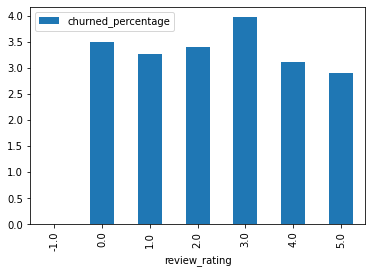

In [576]:
r = dependency_search(purchases, 'review_rating')
r.plot.bar(x="review_rating", y=["churned_percentage"])
r

,order_num,all,churned,churned_percentage
0,1,4395,846.0,19.25
1,2,3515,388.0,11.04
2,3,3106,227.0,7.31
3,4,2855,216.0,7.57
4,5,2615,145.0,5.54
5,6,2450,141.0,5.76
6,7,2278,111.0,4.87
7,8,2145,84.0,3.92
8,9,2037,84.0,4.12
9,10,1925,85.0,4.42


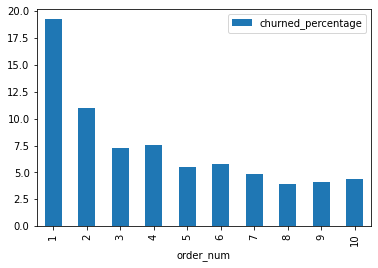

In [577]:
r=dependency_search(purchases, 'order_num')[:10]
r.plot.bar(x="order_num", y=["churned_percentage"])
r

In [578]:
dependency_search(purchases, 'order_source_platform')

,order_source_platform,all,churned,churned_percentage
0,android,26363,1267,4.81
1,ios,49311,1767,3.58
2,web,2653,221,8.33


In [579]:
purchases.groupby(['order_source_platform'])['review_rating'].mean().reset_index()

,order_source_platform,review_rating
0,android,4.399500
1,ios,2.831273
2,web,3.980668


In [580]:
dependency_search(purchases, 'status')

,status,all,churned,churned_percentage
0,deferred_payment_failed,7871,104.0,1.32
1,delivered,67074,3077.0,4.59
2,pending_transaction,25,NaN,NaN
3,process_payment_failed,2,NaN,NaN
4,production,22,7.0,31.82
5,ready,4,1.0,25.00
6,received,3,1.0,33.33
7,refunded,77,6.0,7.79
8,rejected,3249,59.0,1.82


In [581]:
dependency_search(purchases, 'delivery_method')

,delivery_method,all,churned,churned_percentage
0,eatin,866,114,13.16
1,homedelivery,68561,2539,3.70
2,takeaway,8900,602,6.76


In [582]:
purchases.groupby(['delivery_method'])['review_rating'].mean().reset_index()

,delivery_method,review_rating
0,eatin,4.504950
1,homedelivery,3.179557
2,takeaway,3.184299


,end_amount_10,all,churned,churned_percentage
0,0.0,629,60.0,9.54
1,1.0,10902,605.0,5.55
2,2.0,31259,1039.0,3.32
3,3.0,18951,790.0,4.17
4,4.0,9597,425.0,4.43
5,5.0,3573,163.0,4.56
6,6.0,1539,64.0,4.16
7,7.0,725,42.0,5.79
8,8.0,380,27.0,7.11
9,9.0,218,12.0,5.50


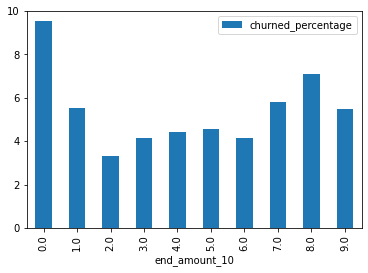

In [583]:
purchases['end_amount_10'] = round(purchases['end_amount']/1000)
r = dependency_search(purchases[purchases['currency']=='EUR'], 'end_amount_10')[:10]
r.plot.bar(x="end_amount_10", y=["churned_percentage"])
r

In [584]:
dependency_search(purchases, 'to_type')

,to_type,all,churned,churned_percentage
0,giftcard,91,13,14.29
1,venue,78236,3242,4.14


In [585]:
preorders_launch = purchases[purchases['preorder'] == True]['time_received'].min()
dependency_search(purchases[purchases['time_received']>=preorders_launch], 'preorder')

,preorder,all,churned,churned_percentage
0,False,47800,2071,4.33
1,True,1727,76,4.40


In [586]:
r = dependency_search(purchases, 'venue__id')
churning_venues = r[r['all']>200].loc[r['churned_percentage']>5]
churning_venues

,venue__id,all,churned,churned_percentage
162,29494778-f867-4a42-9d13-55c2a8e5d094,249,18.0,7.23
179,2ef90738-fbe3-405a-a1ea-2f2477c620b5,694,36.0,5.19
211,36eecf4f-f563-48d2-b850-53fd078b4d85,646,39.0,6.04
311,4b2e8a56-ec6b-43e0-9235-5887d79a558a,290,15.0,5.17
385,5e956b78-3cc8-42d4-b067-27dcb830afe6,295,22.0,7.46
392,5f9bebc3-7adb-466c-95ba-5221d46f6fdb,484,27.0,5.58
395,60944cd9-b2be-4fb7-8ce9-0e27bb106c4d,206,20.0,9.71
468,7199b9b4-9934-4c59-853e-2da11b859c7a,602,36.0,5.98
764,b4e9d5da-9c34-43b5-8b2e-3f095e0edc87,231,21.0,9.09
853,c924e938-4e51-41f1-9d03-3b4631226fdd,363,19.0,5.23


In [587]:
venue_ratings = purchases.groupby(['venue__id'])['review_rating'].mean().reset_index()
general_rating = venue_ratings['review_rating'].mean()
churning_venue_rating = venue_ratings[venue_ratings['venue__id'].isin(churning_venues['venue__id'])]['review_rating'].mean()
print ("average_venue_average_rating: {}".format(round(general_rating,2)))
print ("high_churn_venue_average_rating: {}".format(round(churning_venue_rating,2)))

average_venue_average_rating: 3.15
high_churn_venue_average_rating: 3.5


## Calculating delivery times

In order to see how delivery times affect churn we'll need to calculate them first. Unfortunately the delivery_time field seems not totally reliable — it has values that are both too high and too low. Where possible we'll rely on the time of the delivery status event. 

In [588]:
def parse_events(row):
    new_events = []
    for i in range(20):
        delivery_status_field = 'delivery_status_log_{}_status'.format(i)
        delivery_datetime_field = 'delivery_status_log_{}_datetime'.format(i)
        if pd.isna(row[delivery_status_field]):
            break
        else:
            event = {'event_status':row[delivery_status_field],
                     'event_datetime':row[delivery_datetime_field],
                     'event_num': i,
                     'purchase_id':row['_id']}
            new_events.append(event)
    return new_events

In [589]:
def form_events_list(purchases):
    events_list = []
    
    for j, row in purchases.iterrows():
        
        new_events = parse_events(row)
        events_list.extend(new_events)
        
    return events_list

In [590]:
def create_events_df(purchases):
    events_list = form_events_list(purchases)
    events = pd.DataFrame(events_list)
    
    return events

In [591]:
events = create_events_df(purchases)

In [592]:
def add_event_datetimes(purchases, events):
    for event_status in events['event_status'].unique():
        event_datetimes = events[events['event_status']==event_status][['event_datetime','purchase_id']].groupby('purchase_id').last().reset_index()
        event_datetimes.columns = ['_id',event_status + '_event']
        purchases = pd.merge(purchases,event_datetimes,on='_id',how='left')
    
    return purchases

In [593]:
def remove_df_from_memory(df):
    del [df]
    gc.collect()
    df=pd.DataFrame()

In [594]:
purchases = add_event_datetimes(purchases,events)
remove_df_from_memory(events)

In [595]:
def clean_delivery_minutes(row):
    return row['delivery_minutes']>1 and row['delivery_minutes']<1400 and pd.isna(row['delivered_event'])

In [596]:
def unite_deivery_minutes(purchases):
    purchases['real_delivery_minutes'] = purchases.apply(lambda x: x['delivery_minutes'] if clean_delivery_minutes(x) else x['delivered_event_minutes'], axis=1)
    
    return purchases

In [597]:
def calculate_delivery_minutes(purchases): 
    purchases.loc[purchases['delivered_event'].notnull(), 'delivered_event_minutes'] = (purchases['delivered_event'] - purchases['time_received']).dt.seconds / 60.0
    purchases.loc[purchases['time_delivered'].notnull(), 'delivery_minutes'] = (purchases['time_delivered'] - purchases['time_received']).dt.seconds / 60.0
    purchases = unite_deivery_minutes(purchases)
    return purchases

In [598]:
purchases = calculate_delivery_minutes(purchases)

## Measuring how delivery time affects churn
For this part we are going to work only with the home delivery data

In [599]:
homedelivery_purchases = purchases[purchases['delivery_method']=='homedelivery'].copy()

,real_delivery_min_10,all,churned,churned_percentage
0,0.0,7,NaN,NaN
1,1.0,1088,38.0,3.49
2,2.0,10455,366.0,3.50
3,3.0,15668,600.0,3.83
4,4.0,12872,522.0,4.06
5,5.0,7731,322.0,4.17
6,6.0,4871,250.0,5.13
7,7.0,2352,100.0,4.25
8,8.0,1416,69.0,4.87
9,9.0,814,46.0,5.65


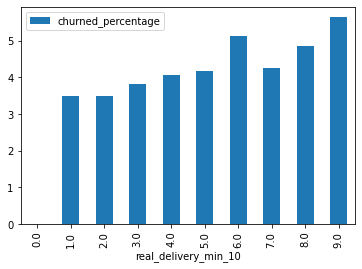

In [600]:
homedelivery_purchases['real_delivery_min_10'] = round(homedelivery_purchases['real_delivery_minutes']/10)
r = dependency_search(homedelivery_purchases, 'real_delivery_min_10')[:10]
r.plot.bar(x="real_delivery_min_10", y=["churned_percentage"])
r

In [601]:
dependency_search(homedelivery_purchases, 'rush_order')

,rush_order,all,churned,churned_percentage
0,False,62429,2277,3.65
1,True,6132,262,4.27


In [602]:
homedelivery_purchases.groupby(['rush_order'])['review_rating'].mean().reset_index()

,rush_order,review_rating
0,False,3.206509
1,True,2.913867


,real_delivery_min_10,all,churned,churned_percentage
0,0.0,7,NaN,NaN
1,1.0,1026,33.0,3.22
2,2.0,9920,343.0,3.46
3,3.0,14656,559.0,3.81
4,4.0,11779,467.0,3.96
5,5.0,6936,281.0,4.05
6,6.0,4277,215.0,5.03
7,7.0,1954,80.0,4.09
8,8.0,1168,61.0,5.22
9,9.0,693,38.0,5.48


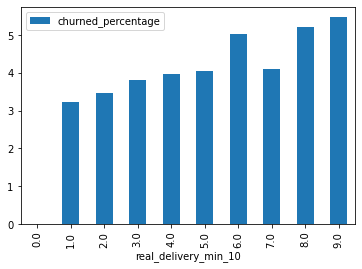

In [603]:
r= dependency_search(homedelivery_purchases.loc[purchases['rush_order']==False], 'real_delivery_min_10')[:10]
r.plot.bar(x="real_delivery_min_10", y=["churned_percentage"])
r

# Calculating expected delivery times and delays
We'll call the delivery time based on the upper boundary "expectation" and on the lower — "hope" 

In [604]:
def define_expected_minutes(purchases):
    expectation_minutes_high = purchases['client_pre_estimate'].map(lambda x : None if pd.isna(x) else float(x.split('-')[-1].strip('+')))
    expectation_minutes_low = purchases['client_pre_estimate'].map(lambda x : None if pd.isna(x) else float(x.split('-')[0].strip('+')))
    return expectation_minutes_high, expectation_minutes_low

In [605]:
def calculate_expectation_diff(purchases):
    expectation_minutes_high, expectation_minutes_low = define_expected_minutes(purchases)
    purchases['expectation_diff_min'] = purchases['real_delivery_minutes'] - expectation_minutes_high
    purchases['hope_diff_min'] = purchases['real_delivery_minutes'] - expectation_minutes_low
    
    return purchases

In [606]:
purchases = calculate_expectation_diff(purchases)

## Measuring how meeting expectations affects churn

,expectation_diff_min_10,all,churned,churned_percentage
13,-5.0,748,22.0,2.94
14,-4.0,2117,67.0,3.16
15,-3.0,5527,168.0,3.04
16,-2.0,11591,472.0,4.07
17,-1.0,15400,598.0,3.88
18,0.0,12156,557.0,4.58
19,1.0,5567,232.0,4.17
20,2.0,2473,122.0,4.93
21,3.0,1067,43.0,4.03
22,4.0,461,28.0,6.07


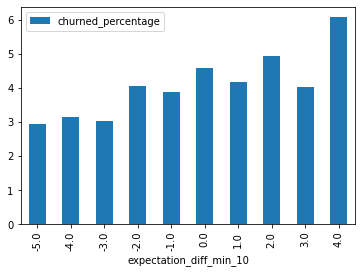

In [607]:
homedelivery_purchases['expectation_diff_min_10'] = round(purchases['expectation_diff_min']/10)
r = dependency_search(homedelivery_purchases, 'expectation_diff_min_10')
r[r['churned']>10].plot.bar(x="expectation_diff_min_10", y=["churned_percentage"])
r[r['churned']>10]

,expectation_diff_min_10,all,churned,churned_percentage
12,-5.0,637,20.0,3.14
13,-4.0,1863,57.0,3.06
14,-3.0,5030,145.0,2.88
15,-2.0,10688,426.0,3.99
16,-1.0,14252,546.0,3.83
17,0.0,11220,504.0,4.49
18,1.0,5029,205.0,4.08
19,2.0,2209,109.0,4.93
20,3.0,929,37.0,3.98
21,4.0,391,23.0,5.88


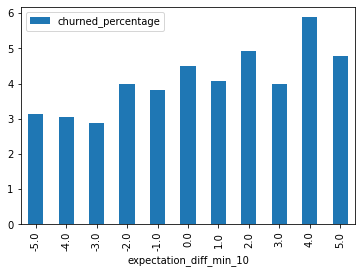

In [608]:
r = dependency_search(homedelivery_purchases.loc[purchases['rush_order']==False], 'expectation_diff_min_10')
r[r['churned']>5].plot.bar(x="expectation_diff_min_10", y=["churned_percentage"])
r[r['churned']>5]

,hope_diff_min_10,all,churned,churned_percentage
12,-4.0,251,16.0,6.37
13,-3.0,831,30.0,3.61
14,-2.0,3431,111.0,3.24
15,-1.0,11059,442.0,4.00
16,-0.0,17459,705.0,4.04
17,1.0,12441,496.0,3.99
18,2.0,6669,277.0,4.15
19,3.0,2991,141.0,4.71
20,4.0,1454,61.0,4.20
21,5.0,617,34.0,5.51


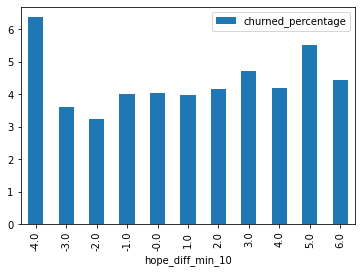

In [609]:
homedelivery_purchases['hope_diff_min_10'] = round(purchases['hope_diff_min']/10)
r = dependency_search(homedelivery_purchases, 'hope_diff_min_10')
r[r['churned']>10].plot.bar(x="hope_diff_min_10", y=["churned_percentage"])
r[r['churned']>10]

## Looking for churn patterns on the first purchase

In [610]:
first_purchases = purchases[purchases['order_num']==1].copy()

,review_rating,all,churned,churned_percentage
0,0.0,72,19,26.39
1,1.0,17,3,17.65
2,2.0,18,4,22.22
3,3.0,43,10,23.26
4,4.0,158,32,20.25
5,5.0,320,70,21.88


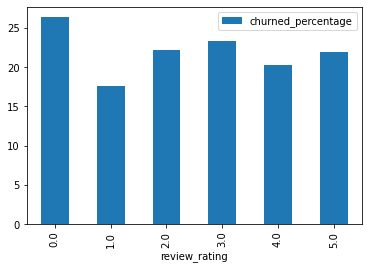

In [611]:
r = dependency_search(first_purchases, 'review_rating')
r.plot.bar(x="review_rating", y=["churned_percentage"])
r

In [612]:
dependency_search(first_purchases, 'order_source_platform')

,order_source_platform,all,churned,churned_percentage
0,android,1697,356,20.98
1,ios,2511,430,17.12
2,web,187,60,32.09


In [613]:
dependency_search(first_purchases, 'status')

,status,all,churned,churned_percentage
0,deferred_payment_failed,330,12.0,3.64
1,delivered,3853,812.0,21.07
2,pending_transaction,2,NaN,NaN
3,process_payment_failed,2,NaN,NaN
4,production,10,5.0,50.00
5,ready,1,NaN,NaN
6,refunded,9,2.0,22.22
7,rejected,188,15.0,7.98


In [614]:
dependency_search(first_purchases, 'delivery_method')

,delivery_method,all,churned,churned_percentage
0,eatin,144,59,40.97
1,homedelivery,3469,531,15.31
2,takeaway,782,256,32.74


,end_amount_10,all,churned,churned_percentage
0,0.0,66,29.0,43.94
1,1.0,674,241.0,35.76
2,2.0,1409,252.0,17.89
3,3.0,1224,181.0,14.79
4,4.0,604,78.0,12.91
5,5.0,232,36.0,15.52
6,6.0,88,9.0,10.23
7,7.0,35,7.0,20.00
8,8.0,19,4.0,21.05
9,9.0,15,NaN,NaN


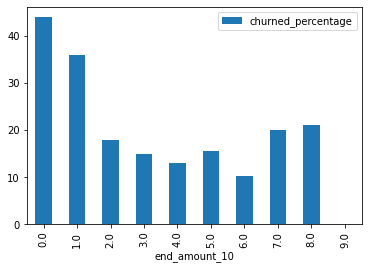

In [615]:
r = dependency_search(first_purchases[first_purchases['currency']=='EUR'], 'end_amount_10')[:10]
r.plot.bar(x="end_amount_10", y=["churned_percentage"])
r

In [616]:
homedelivery_first_purchases = first_purchases[first_purchases['delivery_method']=='homedelivery'].copy()

,real_delivery_min_10,all,churned,churned_percentage
0,0.0,1,NaN,NaN
1,1.0,50,7.0,14.00
2,2.0,648,90.0,13.89
3,3.0,805,105.0,13.04
4,4.0,531,89.0,16.76
5,5.0,286,50.0,17.48
6,6.0,234,58.0,24.79
7,7.0,110,18.0,16.36
8,8.0,66,21.0,31.82
9,9.0,36,14.0,38.89


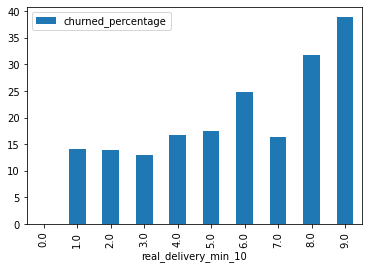

In [617]:
homedelivery_first_purchases['real_delivery_min_10'] = round(homedelivery_first_purchases['real_delivery_minutes']/10)
r = dependency_search(homedelivery_first_purchases, 'real_delivery_min_10')[:10]
r.plot.bar(x="real_delivery_min_10", y=["churned_percentage"])
r

,expectation_diff_min_10,all,churned,churned_percentage
6,-4.0,132,20.0,15.15
7,-3.0,350,40.0,11.43
8,-2.0,708,94.0,13.28
9,-1.0,659,101.0,15.33
10,-0.0,453,105.0,23.18
11,1.0,210,38.0,18.10
12,2.0,94,27.0,28.72
13,3.0,49,12.0,24.49


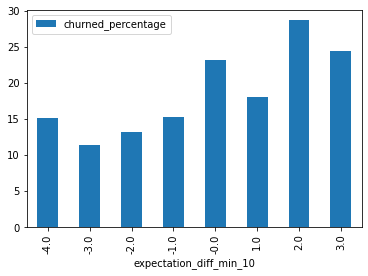

In [618]:
homedelivery_first_purchases['expectation_diff_min_10'] = round(homedelivery_first_purchases['expectation_diff_min']/10)
r = dependency_search(homedelivery_first_purchases, 'expectation_diff_min_10')
r[r['churned']>10].plot.bar(x="expectation_diff_min_10", y=["churned_percentage"])
r[r['churned']>10]

,hope_diff_min_10,all,churned,churned_percentage
4,-3.0,41,8.0,19.51
5,-2.0,160,24.0,15.00
6,-1.0,739,94.0,12.72
7,-0.0,851,152.0,17.86
8,1.0,464,69.0,14.87
9,2.0,258,48.0,18.60
10,3.0,139,32.0,23.02
11,4.0,65,14.0,21.54
12,5.0,27,7.0,25.93


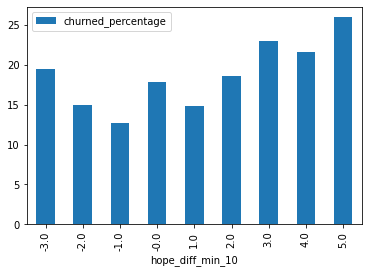

In [619]:
homedelivery_first_purchases['hope_diff_min_10'] = round(homedelivery_first_purchases['hope_diff_min']/10)
r = dependency_search(homedelivery_first_purchases, 'hope_diff_min_10')
r[r['churned']>5].plot.bar(x="hope_diff_min_10", y=["churned_percentage"])
r[r['churned']>5]

## Calculating churn based on length of absence 
First we'll need to calculate the previous purchase for each non-first purchase in the dataset

In [620]:
def generate_previous_dates_list(purchases):
    
    previous_dates_list = []
    saved_date = None
    
    for j, row in purchases.iterrows():
        
        previous_dates_list.append({'_id':row['_id'],'previous_purchase_date':saved_date})

        if row['is_last_purchase']:
            saved_date = None
        else:
            saved_date = row['time_received']
            
    return previous_dates_list

In [621]:
def calculate_previous_dates(purchases):
    previous_dates_list = generate_previous_dates_list(purchases)
    previous_dates = pd.DataFrame(previous_dates_list)
    purchases = pd.merge(purchases,previous_dates,on='_id',how='left')
    purchases['previous_purchase_diff'] = (purchases['time_received'] - purchases['previous_purchase_date']).dt.days
    
    return purchases    

In [622]:
purchases = calculate_previous_dates(purchases)

In [623]:
def calulate_prob_purchase_leads_to_churn(purchases):
    purchases_led_to_churn = len(purchases[purchases['customer_churned']==True])
    prob_purchase_leads_to_churn = purchases_led_to_churn/len(purchases)
    
    return prob_purchase_leads_to_churn
'prob_purchase_leads_to_churn: {}%'.format(round(calulate_prob_purchase_leads_to_churn(purchases)*100, 2))

'prob_purchase_leads_to_churn: 4.16%'

In [624]:
def build_prob_return_by_absence_days(purchases, prob_purchase_leads_to_churn):
    prob_by_absence_days = purchases.groupby(['previous_purchase_diff']).count().reset_index()[['previous_purchase_diff','_id']]
    prob_by_absence_days.columns = ['absence_days','num_returns']
    prob_by_absence_days['num_returns_after_n_days'] = prob_by_absence_days.loc[::-1, 'num_returns'].cumsum()[::-1]
    prob_by_absence_days['portion_returns'] = prob_by_absence_days['num_returns_after_n_days']/len(purchases)
    prob_by_absence_days['prob_return_by_absence_days'] = prob_by_absence_days['portion_returns']*(1-prob_purchase_leads_to_churn)
    
    return prob_by_absence_days

,absence_days,num_returns,num_returns_after_n_days,portion_returns,prob_return_by_absence_days
0,0.0,14706,73932,0.943889,0.904664
1,1.0,5599,59226,0.756138,0.724715
2,2.0,4141,53627,0.684655,0.656203
3,3.0,3446,49486,0.631787,0.605532
4,4.0,3006,46040,0.587792,0.563366
5,5.0,3003,43034,0.549415,0.526583
6,6.0,3092,40031,0.511075,0.489837
7,7.0,2575,36939,0.471600,0.452002
8,8.0,1878,34364,0.438725,0.420493
9,9.0,1621,32486,0.414748,0.397513


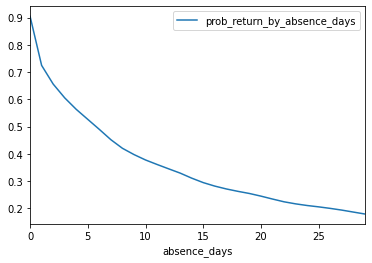

In [625]:
prob_purchase_leads_to_churn = calulate_prob_purchase_leads_to_churn(purchases)
r=build_prob_return_by_absence_days(purchases,prob_purchase_leads_to_churn)[:30]
r.plot(x="absence_days", y=["prob_return_by_absence_days"])
r

## Calculating churn based on length of absence after first purchase


,absence_days,num_returns,num_returns_after_n_days,portion_returns,prob_return_by_absence_days
0,0.0,529,3515,0.444374,0.358836
1,1.0,102,2986,0.377497,0.304832
2,2.0,72,2884,0.364602,0.294419
3,3.0,64,2812,0.355499,0.287069
4,4.0,55,2748,0.347408,0.280535
5,5.0,76,2693,0.340455,0.274920
6,6.0,77,2617,0.330847,0.267162
7,7.0,83,2540,0.321113,0.259301
8,8.0,49,2457,0.310619,0.250828
9,9.0,44,2408,0.304425,0.245826


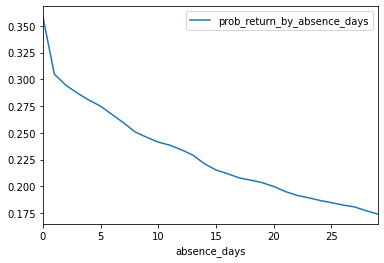

In [626]:
prob_purchase_leads_to_churn = calulate_prob_purchase_leads_to_churn(purchases.loc[purchases['order_num']==1])
r=build_prob_return_by_absence_days(purchases.loc[purchases['order_num']<=2],prob_purchase_leads_to_churn)[:30]
r.plot(x="absence_days", y=["prob_return_by_absence_days"])
r

## Calculating Retention Rate
It would be really cool to make the daily retention chart that everyone is familiar with but unfortunately there is not enough data here

In [627]:
def build_cohort(purchases, date_from, date_to):
    cohort_first_purchase = purchases.loc[purchases['time_received'].dt.date.between(date_from,date_to)].loc[purchases['order_num']==1]
    cohort = cohort_first_purchase['from_field_id'].unique()
    return cohort

In [628]:
def get_retained(purchases, range_start, range_end, cohort):
    retained_purchases = purchases.loc[purchases['time_received'].dt.date.between(range_start,range_end)].loc[purchases['order_num']>1].loc[purchases['from_field_id'].isin(cohort)]
    retained = retained_purchases['from_field_id'].nunique()
    return retained

## Retention Rate of a cohort in each following week

In [629]:
def calculate_retention_rate_of_1_cohort(cohort_from,cohort_to,range_size,purchases):
    date_from = datetime.strptime(cohort_from, '%Y-%m-%d').date() 
    date_to = datetime.strptime(cohort_to, '%Y-%m-%d').date() 

    cohort = build_cohort(purchases, date_from, date_to)
    data_for_plot = []

    for i in range(16):
        range_start = date_to + timedelta(i*range_size)
        range_end = date_to + timedelta((i+1)*range_size)
        retained = get_retained(purchases, range_start,range_end, cohort)
        data_for_plot.append({"range_start": range_start, 'retention_rate': round(100*retained/len(cohort),2)})
    
    rr_of_cohort = pd.DataFrame(data_for_plot)
    
    return rr_of_cohort

<AxesSubplot:xlabel='range_start'>

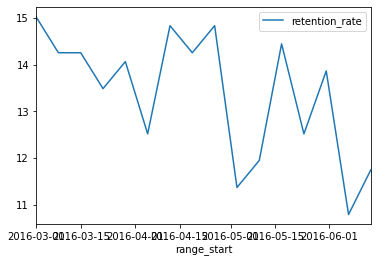

In [630]:
cohort_from = '2016-02-01'
cohort_to = '2016-03-01'
range_size = 7 #weekly

rr_of_cohort = calculate_retention_rate_of_1_cohort(cohort_from,cohort_to,range_size,purchases)
rr_of_cohort.plot(x="range_start", y=["retention_rate"])

## Retention Rate of the 2nd Month by monthly cohorts

In [631]:
def calculate_retention_rate_of_by_cohort(chart_start_date,chart_end_date,cohort_size,range_size,purchases):
    date_from = datetime.strptime(chart_start_date, '%Y-%m-%d').date() 
    date_to = datetime.strptime(chart_end_date, '%Y-%m-%d').date() 

    date = date_from

    data_for_plot = []

    while date <= date_to:
        cohort = build_cohort(purchases,date,date + timedelta(cohort_size))

        range_start = date + timedelta(range_size)
        range_end = date + timedelta(range_size*2)

        retained = get_retained(purchases, range_start, range_end, cohort)

        data_for_plot.append({"range_start": date, 'retention_rate': round(100*retained/len(cohort),2)})

        date = date + timedelta(cohort_size)

    rr_by_cohort = pd.DataFrame(data_for_plot)
    return rr_by_cohort

<AxesSubplot:xlabel='range_start'>

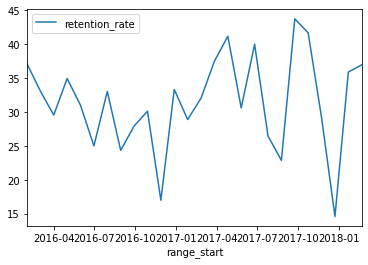

In [632]:
chart_start_date = '2016-02-01'
chart_end_date = '2018-03-01'

cohort_size = 30
range_size = 30

rr_by_cohort = calculate_retention_rate_of_by_cohort(chart_start_date,chart_end_date,cohort_size,range_size,purchases)
rr_by_cohort.plot(x="range_start", y=["retention_rate"])

## Calculating LTV

In [633]:
def calculate_ltv(purchases):
    
    churned_customers = purchases[purchases['customer_churned']]['from_field_id']
    purchases_of_churned_customers = purchases.loc[purchases['from_field_id'].isin(churned_customers)]
    purch_of_c_c_in_euro = purchases_of_churned_customers[purchases_of_churned_customers['currency']=='EUR']
    LTV_by_customer = purch_of_c_c_in_euro.groupby('from_field_id')['end_amount'].sum().reset_index()
    LTV = round(LTV_by_customer['end_amount'].mean()/100,2)
    
    return LTV

In [634]:
first_order_home_customers = purchases.loc[purchases['order_num']==1].loc[purchases['delivery_method']=='homedelivery']['from_field_id']
first_order_takeaway_customers = purchases.loc[purchases['order_num']==1].loc[purchases['delivery_method']=='takeaway']['from_field_id']

web_launch_date = purchases[purchases['order_source_platform']=='web']['time_received'].min()

first_order_ios_customers = purchases.loc[purchases['order_num']==1].loc[purchases['order_source_platform']=='ios'].loc[purchases['time_received']>web_launch_date]['from_field_id']
first_order_android_customers = purchases.loc[purchases['order_num']==1].loc[purchases['order_source_platform']=='android'].loc[purchases['time_received']>web_launch_date]['from_field_id']
first_order_web_customers = purchases.loc[purchases['order_num']==1].loc[purchases['order_source_platform']=='web'].loc[purchases['time_received']>web_launch_date]['from_field_id']

print ('LTV: €{}'.format(calculate_ltv(purchases)))
print ('Home LTV: €{}'.format(calculate_ltv(purchases[purchases['from_field_id'].isin(first_order_home_customers)])))
print ('Takeaway LTV: €{}'.format(calculate_ltv(purchases[purchases['from_field_id'].isin(first_order_takeaway_customers)])))
print ('iOS LTV: €{}'.format(calculate_ltv(purchases[purchases['from_field_id'].isin(first_order_ios_customers)])))
print ('Android LTV: €{}'.format(calculate_ltv(purchases[purchases['from_field_id'].isin(first_order_android_customers)])))
print ('Web LTV: €{}'.format(calculate_ltv(purchases[purchases['from_field_id'].isin(first_order_web_customers)])))


LTV: €277.7
Home LTV: €313.04
Takeaway LTV: €176.46
iOS LTV: €144.4
Android LTV: €129.1
Web LTV: €129.41


In [635]:
purchases.groupby('order_source_platform')['end_amount'].mean().reset_index()

,order_source_platform,end_amount
0,android,2688.780564
1,ios,2800.341222
2,web,3171.965699


## Investigating what contributes to long/delayed deliveries

In [637]:
def calculate_delivery_stages(purchases):

    purchases.loc[purchases['delivered_event'].notna() & purchases['courier_at_delivery_location_event'].notna(), 'last_mile_minutes'] = (purchases['delivered_event']-purchases['courier_at_delivery_location_event']).dt.total_seconds()/60
    purchases.loc[purchases['picked_up_event'].notna() & purchases['courier_at_delivery_location_event'].notna(), 'from_venue_to_customer_minutes'] = (purchases['courier_at_delivery_location_event']-purchases['picked_up_event']).dt.total_seconds()/60
    purchases.loc[purchases['picked_up_event'].notna() & purchases['courier_at_venue_event'].notna(), 'waiting_at_venue_minutes'] = (purchases['picked_up_event']-purchases['courier_at_venue_event']).dt.total_seconds()/60
    purchases.loc[purchases['picked_up_event'].notna() & purchases['pickup_eta'].notna(), 'pickup_delay_minutes'] = (purchases['picked_up_event']-purchases['pickup_eta']).dt.total_seconds()/60
    purchases.loc[purchases['time_received'].notna() & purchases['picked_up_event'].notna(), 'cooking_minutes'] = (purchases['picked_up_event']-purchases['time_received']).dt.total_seconds()/60

    print(purchases['last_mile_minutes'].mean(),
    purchases['from_venue_to_customer_minutes'].mean(),
    purchases[purchases['waiting_at_venue_minutes']<100]['waiting_at_venue_minutes'].mean(),
    purchases[purchases['pickup_delay_minutes']<100]['pickup_delay_minutes'].mean(),
    purchases[purchases['cooking_minutes']<100]['cooking_minutes'].mean())


In [638]:
long_first_deliveries = homedelivery_first_purchases[homedelivery_first_purchases['expectation_diff_min_10']>=0].copy()
long_deliveries = homedelivery_purchases[homedelivery_purchases['real_delivery_min_10']>=60].copy()

calculate_delivery_stages(purchases)
calculate_delivery_stages(long_first_deliveries)
calculate_delivery_stages(long_deliveries)

3.663571243231766 11.850602320576533 5.731789571204141 1.7733870909798786 23.837451748916045
4.68780945595855 14.871763946459415 7.604291666666666 4.0236981409425 34.31597460422164
4.003701666666667 12.122592741935485 8.832313846153847 1.7600833333333334 32.78851458333333
